# pytorch를 이용한 뉴럴 변환(Neural Transform)
이 [링크](https://tutorials.pytorch.kr/advanced/neural_style_tutorial.html#id5)를 참고하여 튜토리얼을 진행하고 이해한다.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

gpu를 사용할 수 있는지 확인.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print(device)

cuda


In [70]:
# 원하는 출력 이미지의 크기
imsize = 512 if torch.cuda.is_available() else 128  # 만약 GPU가 없을 경우 작은 크기를 사용

loader = transforms.Compose([
    transforms.Resize(imsize),  # 가져온 이미지 크기 조정
    transforms.ToTensor()])  # 텐서로 변환


def image_loader(image_name):
    image = Image.open(image_name)
    # 네트워크의 입력 차원에 맞추기 위해 필요한 가짜 배치 차원
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./images/picasso.jpg")
content_img = image_loader("./images/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

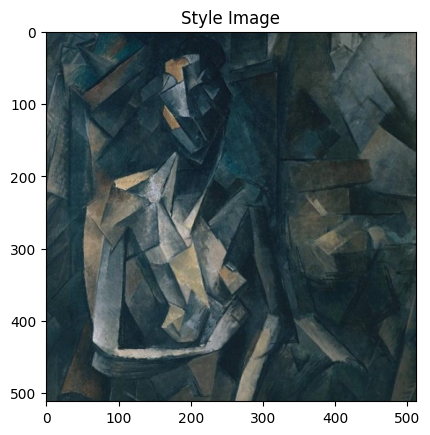

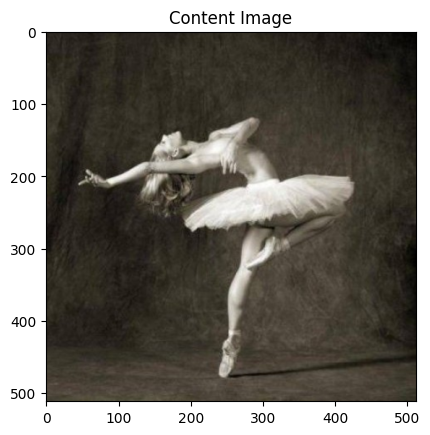

In [71]:
unloader = transforms.ToPILImage()  # PIL 이미지로 다시 변환

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # 텐서를 복제하여 변경하지 않음
    image = image.squeeze(0)      # 가짜 배치 차원 제거
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # plots가 업데이트 되도록 잠시 멈춤


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [72]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # 기울기를 동적으로 계산하는데 사용되는 tree로부터 타깃 Content를 `분리(detach)` 합니다.
        # 이것은 변수가 아니라 명시된 값입니다.
        # 그렇지 않으면 criterion의 forward 메소드에서 오류가 발생합니다.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [73]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=배치 크기(=1)
    # b=특징 맵의 수
    # (c,d)=특징 맵의 차원 (N=c*d)

    features = input.view(a * b, c * d)  # F_XL을 \hat F_XL로 크기 조정

    G = torch.mm(features, features.t())  # gram product를 계산

    # 각 특징 맵이 갖는 값의 수로 나누어
    # gram 행렬의 값을 '정규화'
    return G.div(a * b * c * d)

In [74]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

모델 가져오기

In [75]:
from torchvision.models import vgg19, VGG19_Weights

cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [76]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# 입력 이미지를 정규화하는 모듈을 생성하여 쉽게 ``nn.Sequential`` 에 넣을 수 있습니다.
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view 는 mean과 std을 확인해 [B x C x H x W] 형태의
        # 이미지 텐서를 직접적으로 작업할 수 있도록 [C x 1 x 1] 형태로 만듭니다.
        # B는 배치 크기입니다. C는 채널의 수입니다. H는 높이고 W는 너비입니다.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # ``img`` 정규화
        return (img - self.mean) / self.std

In [77]:
# Style / Content 손실 계산을 원하는 계층
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # 모듈 정규화
    normalization = Normalization(normalization_mean, normalization_std)

    # Content / Style 손실이 반복적으로 접근할 수 있도록 하기 위해
    content_losses = []
    style_losses = []

    # ``cnn`` 이 ``nn.Sequential`` 이라고 가정하고,
    # 순차적으로 활성화되어야 하는 모듈에 새로운 ``nn.Sequential`` 을 만듭니다.
    model = nn.Sequential(normalization)

    i = 0  # conv를 볼 때마다 증가
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # 아래에 추가한 ``ContentLoss`` 와 ``StyleLoss`` 는 in-place 버전에서는 잘 동작하지 않습니다.
            # 그래서 여기서는 out-of-place로 대체합니다.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # Content 손실 추가
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # Style 손실 추가
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 이제 마지막 Content 및 Style 손실 뒤에 계층을 잘라냅니다.
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

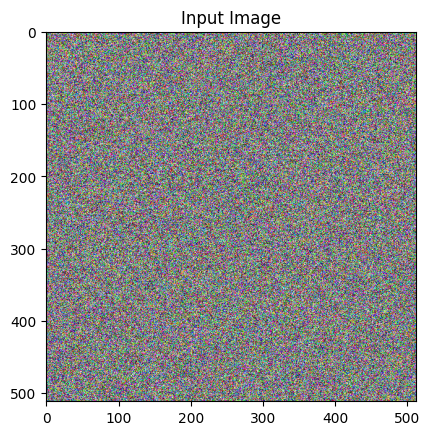

In [82]:
input_img = torch.randn(content_img.data.size())
# 만약 화이트 노이즈(white noise)을 사용하려면 아래 주석을 제거하세요:
#
# ::
#
input_img = torch.randn(content_img.data.size(), device=device)

# 그림에 원본 입력 이미지를 추가합니다.
plt.figure()
imshow(input_img, title='Input Image')

In [83]:
def get_input_optimizer(input_img):
    # 입력이 기울기가 필요한 매개 변수임을 표시하는 줄
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [84]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # 모델의 매개변수를 제외한 입력을 최적화해야 하므로
    # 이에 맞춰서 requires_grad 값을 갱신합니다.
    input_img.requires_grad_(True)
    # 또한, 모델을 평가(eval) 모드로 전환하여
    # 드롭아웃(dropout) 및 배치 정규화(batch normalization)와 같은 특정 레이어가 올바르게 동작하도록 합니다.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # 업데이트 된 입력 이미지의 값을 수정
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # 마지막 수정...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 83.093452 Content Loss: 11.802673

run [100]:
Style Loss : 22.927900 Content Loss: 9.437992

run [150]:
Style Loss : 4.966661 Content Loss: 7.378031

run [200]:
Style Loss : 1.882763 Content Loss: 5.710613

run [250]:
Style Loss : 1.253418 Content Loss: 4.732593

run [300]:
Style Loss : 0.937047 Content Loss: 4.098165



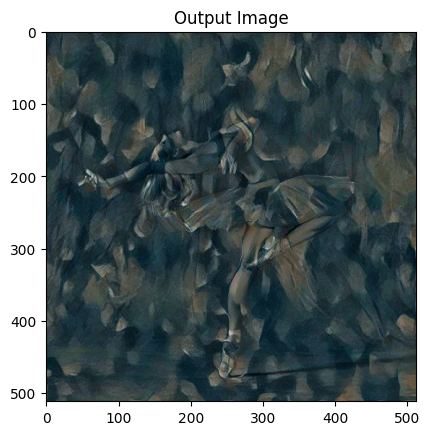

In [85]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()